# Real-Time Multi-Object Tracking in Video Streams
### Ajmal Jalal, Aliaksei Matsarski - Team 2
### AAI-521-05 Applied Computer Vision for AI
### Instructor: Mohammad Yavarimanesh, Ph.D
### Shiley-Marcos School of Engineering, University of San Diego
#### November 29, 2025

# 1. Project Overview

## Objective
This project implements a **Real-Time Multi-Object Tracking (MOT)** system that can detect, track, and classify multiple objects in video sequences. Our system combines deep learning-based object detection (YOLOv8) with tracking algorithms (SORT/DeepSORT) to maintain object identities across frames.

## Key Goals
1. **Object Detection**: Detect pedestrians and other objects using YOLOv8
2. **Multi-Object Tracking**: Assign and maintain unique IDs across frames
3. **Occlusion Handling**: Re-identify objects after temporary occlusions
4. **Performance Metrics**: Achieve competitive MOTA and IDF1 scores on MOT20 benchmark

## Dataset
- **Primary**: MOT20 (Multiple Object Tracking Benchmark) - 8,931 frames of crowded urban scenes
- **Format**: 1920×1080 resolution, 25 FPS, with bounding box annotations

## Approach
1. **Data Pipeline**: Load, validate, and preprocess MOT20 dataset
2. **Detection**: Fine-tune YOLOv8 on MOT20 pedestrian annotations
3. **Tracking**: Implement SORT/DeepSORT for temporal association
4. **Evaluation**: Measure performance using standard MOT metrics

# 2. Data Pipeline & Preprocessing

This section covers the complete data pipeline for the MOT20 dataset:

| Step | Description |
|------|-------------|
| **2.1** | Environment setup and dependency installation |
| **2.2** | Dataset loading and organization |
| **2.3** | Exploratory Data Analysis (EDA) |
| **2.4** | Data quality checks and validation |
| **2.5** | Preprocessing pipeline with augmentation |

The pipeline transforms raw MOT20 data into YOLO-compatible format for training.

## 2.1 Environment Setup

Install required packages for object detection, tracking, and visualization.

**Dependencies:**
- `ultralytics`: YOLOv8 framework for object detection
- `opencv-python`: Image/video processing
- `roboflow`: Dataset management utilities
- `matplotlib/seaborn`: Visualization
- `pandas`: Data manipulation

In [13]:
# ============================================================================
# INSTALL DEPENDENCIES
# ============================================================================

%pip install -q roboflow ultralytics opencv-python matplotlib seaborn pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 88.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 127.0 MB/s eta 0:00:00


In [12]:
# ============================================================================
# IMPORT LIBRARIES AND CONFIGURE PATHS
# ============================================================================

import os
import glob
import zipfile
from pathlib import Path
from typing import Dict, List, Tuple, Optional
from dataclasses import dataclass

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from google.colab import drive

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")

✓ All libraries imported successfully


In [14]:
# ============================================================================
# DATASET LOADING FUNCTIONS
# ============================================================================

def load_sequence_info(seq_path: str) -> Dict:
    """
    Load sequence metadata from seqinfo.ini file.

    Args:
        seq_path: Path to the sequence directory

    Returns:
        Dictionary with sequence metadata (name, length, fps, etc.)
    """
    info_path = os.path.join(seq_path, "seqinfo.ini")
    info = {"name": os.path.basename(seq_path)}

    if os.path.exists(info_path):
        with open(info_path, "r") as f:
            for line in f:
                if "=" in line:
                    key, value = line.strip().split("=")
                    info[key.lower()] = value
    return info


def load_ground_truth(seq_path: str, columns: List[str]) -> pd.DataFrame:
    """
    Load ground truth annotations for a sequence.

    Args:
        seq_path: Path to the sequence directory
        columns: Column names for the annotation file

    Returns:
        DataFrame with ground truth annotations
    """
    gt_path = os.path.join(seq_path, "gt", "gt.txt")

    if not os.path.exists(gt_path):
        raise FileNotFoundError(f"Ground truth not found: {gt_path}")

    gt_df = pd.read_csv(gt_path, names=columns)
    gt_df["sequence"] = os.path.basename(seq_path)

    return gt_df


def get_all_sequences(base_dir: str) -> List[str]:
    """
    Get list of all training sequence paths.

    Args:
        base_dir: Base directory of MOT20 dataset

    Returns:
        Sorted list of sequence directory paths
    """
    train_dir = os.path.join(base_dir, "train")
    sequences = sorted(glob.glob(os.path.join(train_dir, "MOT20-*")))
    return sequences

## 2.2 Dataset Loading & Organization

Define configuration settings and helper functions for loading the MOT20 dataset.

**MOT20 Dataset Structure:**
```
MOT20/
├── train/
│   ├── MOT20-01/
│   │   ├── img1/          # Video frames as JPEG images
│   │   ├── gt/gt.txt      # Ground truth annotations
│   │   ├── det/det.txt    # Public detections
│   │   └── seqinfo.ini    # Sequence metadata
│   ├── MOT20-02/
│   └── ...
└── test/
    └── ...
```



In [ ]:
# ============================================================================
# MOUNT GOOGLE DRIVE AND EXTRACT DATASET
# ============================================================================
# This cell handles Google Drive mounting and dataset extraction.
# If mount fails, try: Runtime -> Restart runtime, then run cells again.

import os # Import the os module
from google.colab import drive

def setup_dataset(config):
    """
    Mount Google drive, download MOT20 dataset if not present, and extract it.
    """
    # Step 1: Mount Drive
    drive.mount('/content/drive')

    # Define the path for the zip file in Google Drive
    zip_path = os.path.join(config.drive_dir, "MOT20.zip")
    file_url = "https://motchallenge.net/data/MOT20.zip"

    # Step 2: Check if zip file exists in Drive, if not, download it
    if not os.path.exists(zip_path):
        print(f"Dataset not found at: {zip_path}")
        print(f"Downloading {file_url} to {zip_path}...")
        # Use subprocess for wget to ensure proper execution and error handling
        import subprocess
        try:
            subprocess.run(
                ["wget", "-O", zip_path, file_url],
                check=True,  # Raise an exception for non-zero exit codes
                capture_output=True, text=True
            )
            print("✓ Download complete!")
        except subprocess.CalledProcessError as e:
            print(f"Error during download: {e.stderr}")
            print("Dataset setup incomplete. Please check network connection or URL and re-run this cell.")
            return False
        except Exception as e:
            print(f"An unexpected error occurred during download: {e}")
            return False
    else:
        print(f"✓ Found dataset: {zip_path}")

    # Step 3: Extract if needed
    # Check if the extracted directory (e.g., MOT20/train) exists
    if os.path.exists(config.base_dir) and os.path.exists(f"{config.base_dir}/train"):
        print(f"✓ MOT20 already extracted at {config.base_dir}")
    else:
        print("Extracting MOT20 dataset (this may take a few minutes)...")
        import subprocess
        result = subprocess.run(
            ["unzip", "-q", zip_path, "-d", "/content/"],
            capture_output=True, text=True
        )
        if result.returncode != 0:
            print(f"Extraction failed: {result.stderr}")
            # Clean up partially extracted files if any
            if os.path.exists(config.base_dir):
                import shutil
                shutil.rmtree(config.base_dir)
            print("Dataset setup incomplete. Please fix the issues above and re-run this cell.")
            return False
        print("✓ Extraction complete!")

    return True

In [27]:
sequences = get_all_sequences(config.base_dir)

if sequences:
    print(f"✓ Found {len(sequences)} training sequences:")
    for seq in sequences:
        print(f"   - {os.path.basename(seq)}")
else:
    print("No sequences found!")
    print("   Make sure the previous cell (Mount & Extract) completed successfully.")
    print("   Then re-run this cell.")

✓ Found 4 training sequences:
   - MOT20-01
   - MOT20-02
   - MOT20-03
   - MOT20-05


In [28]:
# ============================================================================
# LOAD ALL GROUND TRUTH DATA
# ============================================================================

def load_all_ground_truth(sequences: List[str], config: Config) -> pd.DataFrame:
    """
    Load and combine ground truth from all sequences.

    Args:
        sequences: List of sequence directory paths
        config: Configuration object with column names

    Returns:
        Combined DataFrame with all annotations
    """
    if not sequences:
        raise ValueError(
            "No sequences provided!\n"
            "Run the 'Mount & Extract' and 'Reload Sequences' cells first."
        )

    all_gt = []

    for seq_path in sequences:
        try:
            gt_df = load_ground_truth(seq_path, config.gt_columns)
            seq_info = load_sequence_info(seq_path)

            # Add sequence metadata
            gt_df["imwidth"] = int(seq_info.get("imwidth", 1920))
            gt_df["imheight"] = int(seq_info.get("imheight", 1080))

            all_gt.append(gt_df)
            print(f"   ✓ Loaded {os.path.basename(seq_path)}: {len(gt_df):,} annotations")
        except FileNotFoundError as e:
            print(f"   Skipping {os.path.basename(seq_path)}: {e}")

    if not all_gt:
        raise ValueError("No ground truth data loaded!")

    return pd.concat(all_gt, ignore_index=True)


# Load all ground truth data
print("Loading ground truth annotations...")
gt_all = load_all_ground_truth(sequences, config)

# Display summary
print(f"\n✓ Total: {len(gt_all):,} annotations")
print(f"  - Unique objects: {gt_all['id'].nunique():,}")
print(f"  - Total frames: {gt_all.groupby('sequence')['frame'].nunique().sum():,}")
print(f"\nSample data:")
gt_all.head()

Loading ground truth annotations...
   ✓ Loaded MOT20-01: 26,647 annotations
   ✓ Loaded MOT20-02: 202,215 annotations
   ✓ Loaded MOT20-03: 356,728 annotations
   ✓ Loaded MOT20-05: 751,330 annotations

✓ Total: 1,336,920 annotations
  - Unique objects: 1,211
  - Total frames: 8,931

Sample data:


,frame,id,x,y,w,h,conf,class,visibility,sequence,imwidth,imheight
0,1,1,199,813,140,268,1,1,0.83643,MOT20-01,1920,1080
1,2,1,201,812,140,268,1,1,0.84015,MOT20-01,1920,1080
2,3,1,203,812,140,268,1,1,0.84015,MOT20-01,1920,1080
3,4,1,206,812,140,268,1,1,0.84015,MOT20-01,1920,1080
4,5,1,208,812,140,268,1,1,0.84015,MOT20-01,1920,1080


## 2.3 Exploratory Data Analysis (EDA)

Comprehensive analysis of the MOT20 dataset to understand:
- **Dataset statistics**: Frame counts, object counts per sequence
- **Bounding box distributions**: Size, aspect ratio, position
- **Occlusion patterns**: Visibility scores across the dataset
- **Object density**: How crowded are the scenes?

In [18]:
# ============================================================================
# DATASET STATISTICS BY SEQUENCE
# ============================================================================

def compute_sequence_stats(gt_df: pd.DataFrame) -> pd.DataFrame:
    """
    Compute summary statistics for each sequence.

    Args:
        gt_df: Combined ground truth DataFrame

    Returns:
        DataFrame with per-sequence statistics
    """
    stats = gt_df.groupby("sequence").agg({
        "frame": "nunique",
        "id": "nunique",
        "visibility": "mean",
        "w": "mean",
        "h": "mean"
    }).round(2)

    stats.columns = ["Frames", "Unique Objects", "Avg Visibility", "Avg Width", "Avg Height"]

    # Add objects per frame
    objects_per_frame = gt_df.groupby(["sequence", "frame"])["id"].count().groupby("sequence").mean()
    stats["Avg Objects/Frame"] = objects_per_frame.round(1)

    return stats


# Compute and display statistics
sequence_stats = compute_sequence_stats(gt_all)
print("Dataset Statistics by Sequence:\n")
sequence_stats

Dataset Statistics by Sequence:



,Frames,Unique Objects,Avg Visibility,Avg Width,Avg Height,Avg Objects/Frame
sequence,,,,,,
MOT20-01,429,90,0.55,86.68,183.20,62.1
MOT20-02,2782,296,0.52,88.75,194.59,72.7
MOT20-03,2405,735,0.66,48.01,96.57,148.3
MOT20-05,3315,1211,0.53,63.80,145.01,226.6


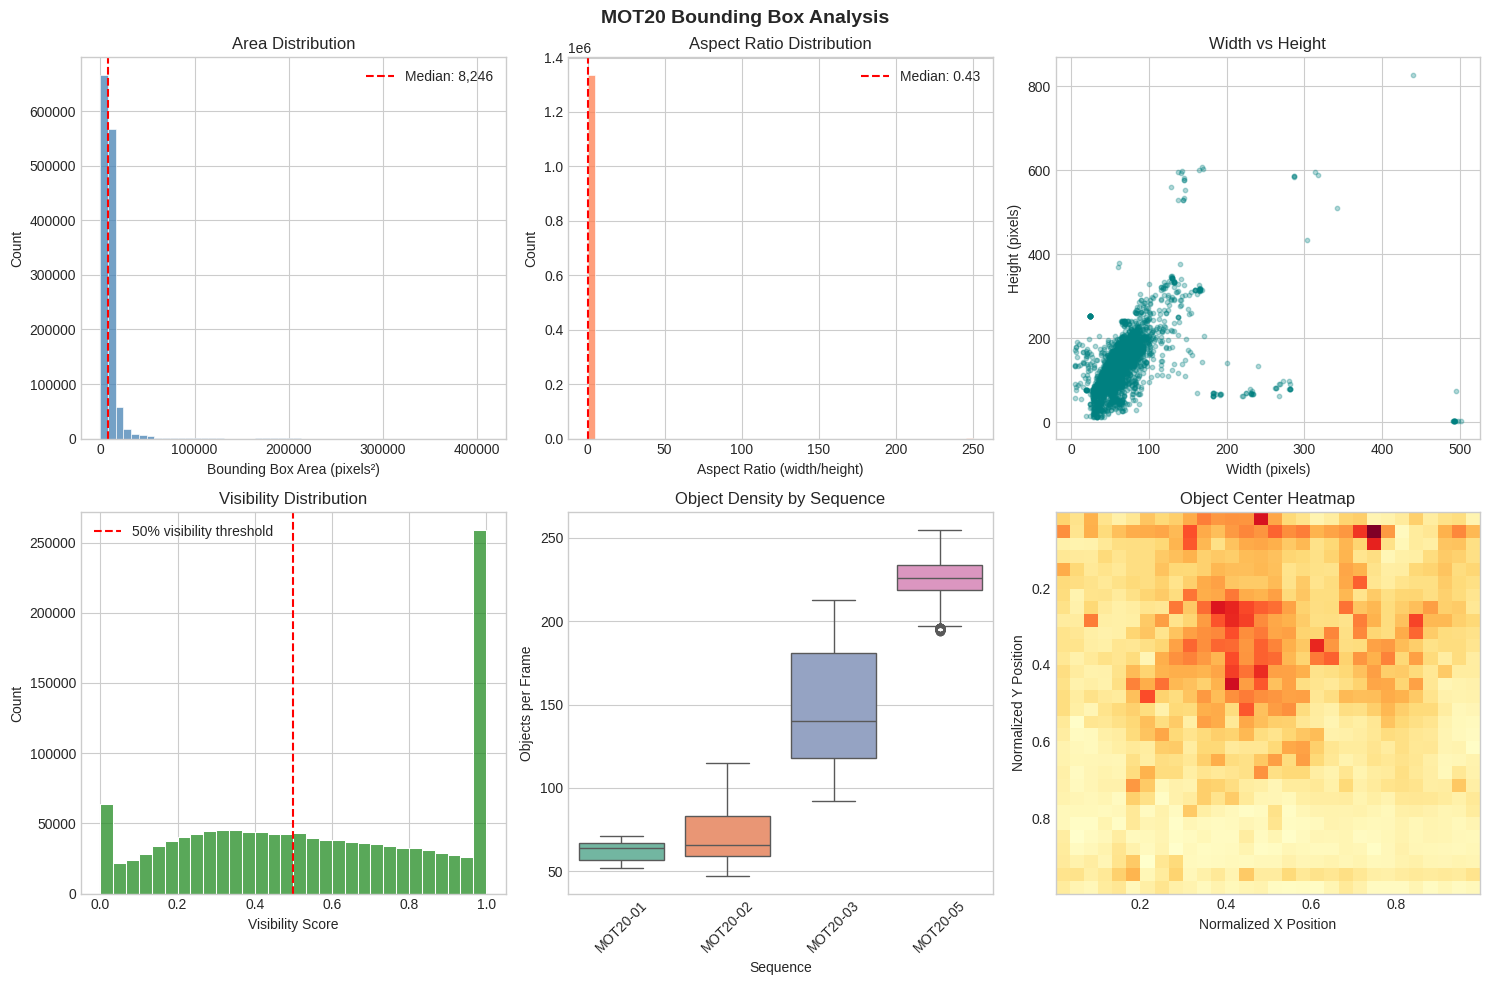

In [19]:
# ============================================================================
# BOUNDING BOX DISTRIBUTION VISUALIZATION
# ============================================================================

def plot_bbox_distributions(gt_df: pd.DataFrame):
    """
    Create comprehensive visualizations of bounding box distributions.

    Args:
        gt_df: Ground truth DataFrame with bbox columns
    """
    # Compute derived features
    gt_df = gt_df.copy()
    gt_df["area"] = gt_df["w"] * gt_df["h"]
    gt_df["aspect_ratio"] = gt_df["w"] / gt_df["h"]
    gt_df["center_x"] = gt_df["x"] + gt_df["w"] / 2
    gt_df["center_y"] = gt_df["y"] + gt_df["h"] / 2

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle("MOT20 Bounding Box Analysis", fontsize=14, fontweight="bold")

    # 1. Area distribution
    ax1 = axes[0, 0]
    sns.histplot(gt_df["area"], bins=50, ax=ax1, color="steelblue", edgecolor="white")
    ax1.set_xlabel("Bounding Box Area (pixels²)")
    ax1.set_ylabel("Count")
    ax1.set_title("Area Distribution")
    ax1.axvline(gt_df["area"].median(), color="red", linestyle="--", label=f"Median: {gt_df['area'].median():,.0f}")
    ax1.legend()

    # 2. Aspect ratio distribution
    ax2 = axes[0, 1]
    sns.histplot(gt_df["aspect_ratio"], bins=50, ax=ax2, color="coral", edgecolor="white")
    ax2.set_xlabel("Aspect Ratio (width/height)")
    ax2.set_ylabel("Count")
    ax2.set_title("Aspect Ratio Distribution")
    ax2.axvline(gt_df["aspect_ratio"].median(), color="red", linestyle="--", label=f"Median: {gt_df['aspect_ratio'].median():.2f}")
    ax2.legend()

    # 3. Width vs Height scatter
    ax3 = axes[0, 2]
    sample = gt_df.sample(min(5000, len(gt_df)))  # Sample for performance
    ax3.scatter(sample["w"], sample["h"], alpha=0.3, s=10, c="teal")
    ax3.set_xlabel("Width (pixels)")
    ax3.set_ylabel("Height (pixels)")
    ax3.set_title("Width vs Height")

    # 4. Visibility distribution
    ax4 = axes[1, 0]
    sns.histplot(gt_df["visibility"], bins=30, ax=ax4, color="forestgreen", edgecolor="white")
    ax4.set_xlabel("Visibility Score")
    ax4.set_ylabel("Count")
    ax4.set_title("Visibility Distribution")
    ax4.axvline(0.5, color="red", linestyle="--", label="50% visibility threshold")
    ax4.legend()

    # 5. Objects per frame by sequence
    ax5 = axes[1, 1]
    objects_per_frame = gt_df.groupby(["sequence", "frame"])["id"].count().reset_index()
    sns.boxplot(data=objects_per_frame, x="sequence", y="id", ax=ax5, palette="Set2")
    ax5.set_xlabel("Sequence")
    ax5.set_ylabel("Objects per Frame")
    ax5.set_title("Object Density by Sequence")
    ax5.tick_params(axis="x", rotation=45)

    # 6. Center position heatmap
    ax6 = axes[1, 2]
    # Normalize to percentage of image
    norm_x = gt_df["center_x"] / gt_df["imwidth"]
    norm_y = gt_df["center_y"] / gt_df["imheight"]
    ax6.hist2d(norm_x, norm_y, bins=30, cmap="YlOrRd")
    ax6.set_xlabel("Normalized X Position")
    ax6.set_ylabel("Normalized Y Position")
    ax6.set_title("Object Center Heatmap")
    ax6.invert_yaxis()  # Match image coordinates

    plt.tight_layout()
    plt.show()


# Generate visualizations
plot_bbox_distributions(gt_all)

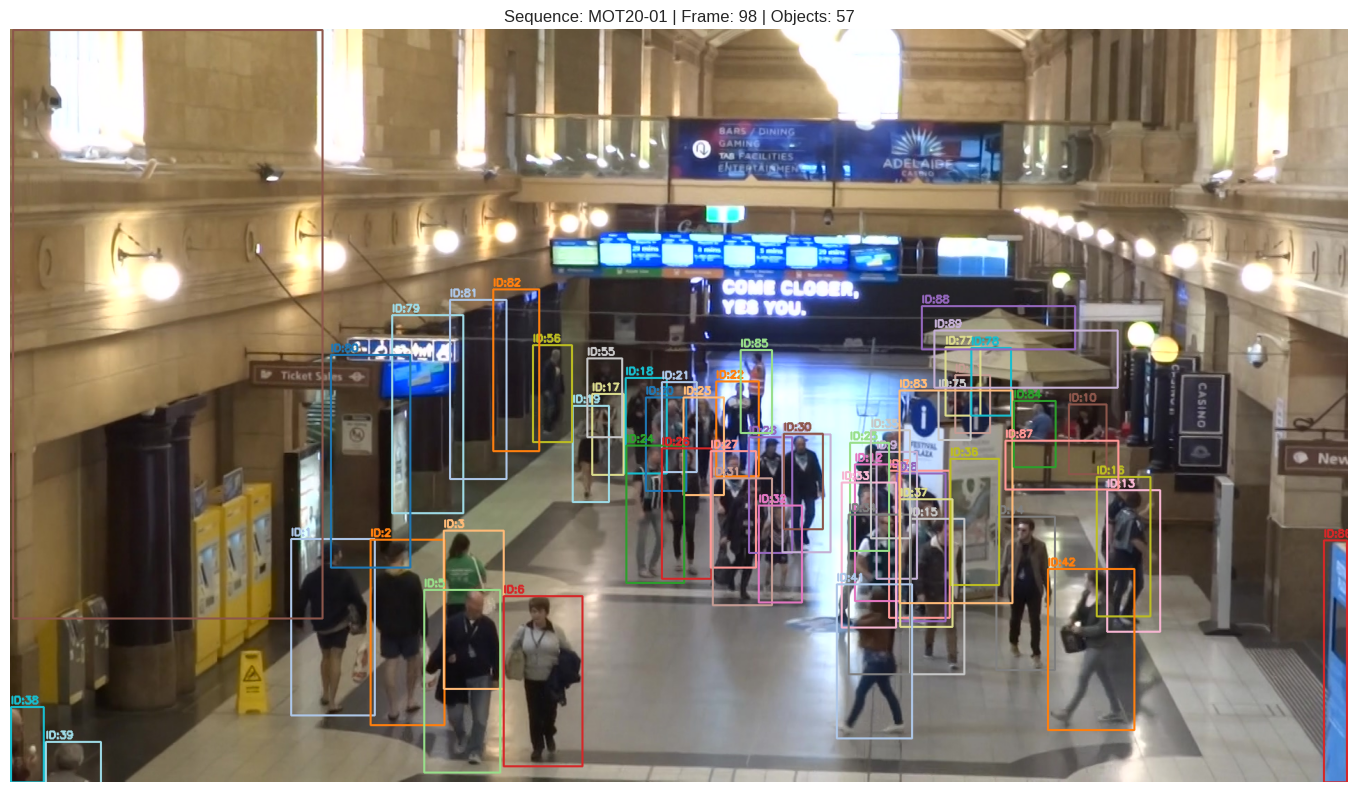

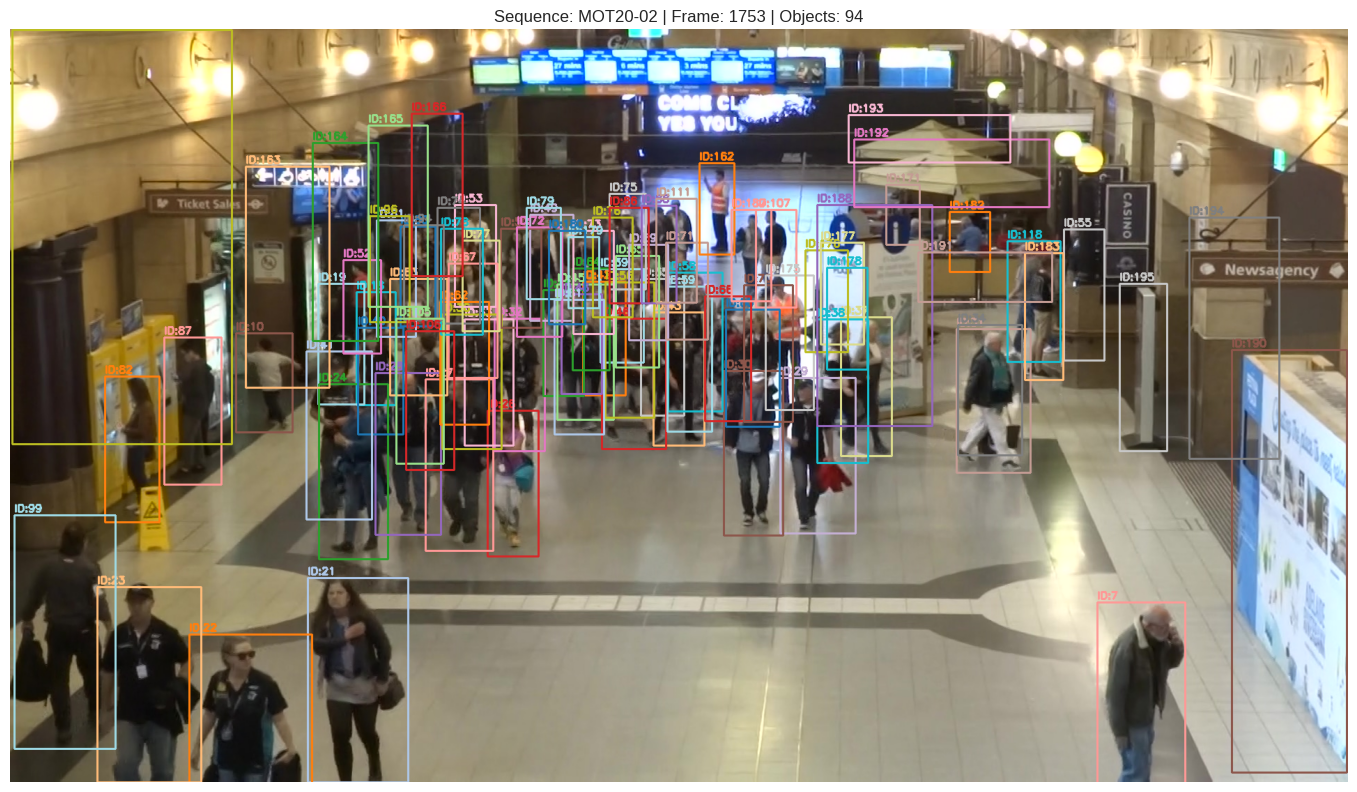

In [20]:
# ============================================================================
# SAMPLE FRAME VISUALIZATION
# ============================================================================

def visualize_sample_frame(seq_path: str, gt_df: pd.DataFrame, frame_num: Optional[int] = None):
    """
    Display a sample frame with ground truth bounding boxes.

    Args:
        seq_path: Path to sequence directory
        gt_df: Ground truth DataFrame
        frame_num: Optional specific frame number (random if None)
    """
    seq_name = os.path.basename(seq_path)
    seq_gt = gt_df[gt_df["sequence"] == seq_name]

    # Select frame
    if frame_num is None:
        frame_num = seq_gt["frame"].sample(1).iloc[0]

    # Load image
    img_path = os.path.join(seq_path, "img1", f"{frame_num:06d}.jpg")
    img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

    # Draw bounding boxes
    frame_gt = seq_gt[seq_gt["frame"] == frame_num]
    colors = plt.cm.tab20(np.linspace(0, 1, 20))

    for _, row in frame_gt.iterrows():
        x, y, w, h = int(row.x), int(row.y), int(row.w), int(row.h)
        color = tuple(int(c * 255) for c in colors[int(row.id) % 20][:3])

        # Draw rectangle
        cv2.rectangle(img, (x, y), (x + w, y + h), color, 2)

        # Draw ID label
        label = f"ID:{int(row.id)}"
        cv2.putText(img, label, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Display
    plt.figure(figsize=(14, 8))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Sequence: {seq_name} | Frame: {frame_num} | Objects: {len(frame_gt)}", fontsize=12)
    plt.tight_layout()
    plt.show()

    return frame_num


# Visualize samples from each sequence
for seq in sequences[:2]:  # Show first 2 sequences
    visualize_sample_frame(seq, gt_all)

## 2.4 Data Quality Checks & Validation

Before preprocessing, we perform quality checks to identify potential issues:
- **Missing values**: Check for null/NaN entries
- **Invalid coordinates**: Negative values or out-of-bounds boxes
- **Visibility filtering**: Decide threshold for heavily occluded objects
- **Class distribution**: Ensure balanced representation

In [26]:
# ============================================================================
# DATA QUALITY VALIDATION
# ============================================================================

def validate_ground_truth(gt_df: pd.DataFrame) -> Dict:
    """
    Perform comprehensive data quality checks on ground truth.

    Args:
        gt_df: Ground truth DataFrame

    Returns:
        Dictionary with validation results
    """
    results = {}

    # 1. Check for missing values
    missing = gt_df.isnull().sum()
    results["missing_values"] = missing[missing > 0].to_dict()

    # 2. Check for negative coordinates
    negative_x = (gt_df["x"] < 0).sum()
    negative_y = (gt_df["y"] < 0).sum()
    negative_w = (gt_df["w"] <= 0).sum()
    negative_h = (gt_df["h"] <= 0).sum()
    results["invalid_coords"] = {
        "negative_x": negative_x,
        "negative_y": negative_y,
        "zero_or_negative_width": negative_w,
        "zero_or_negative_height": negative_h
    }

    # 3. Check for out-of-bounds boxes
    out_of_bounds = (
        (gt_df["x"] + gt_df["w"] > gt_df["imwidth"]) |
        (gt_df["y"] + gt_df["h"] > gt_df["imheight"])
    ).sum()
    results["out_of_bounds"] = out_of_bounds

    # 4. Check confidence filtering (MOT convention: conf=1 means valid)
    valid_conf = (gt_df["conf"] == 1).sum()
    invalid_conf = (gt_df["conf"] != 1).sum()
    results["confidence"] = {
        "valid (conf=1)": valid_conf,
        "invalid (conf≠1)": invalid_conf
    }

    # 5. Visibility statistics
    low_visibility = (gt_df["visibility"] < 0.3).sum()
    medium_visibility = ((gt_df["visibility"] >= 0.3) & (gt_df["visibility"] < 0.7)).sum()
    high_visibility = (gt_df["visibility"] >= 0.7).sum()
    results["visibility_distribution"] = {
        "low (<0.3)": low_visibility,
        "medium (0.3-0.7)": medium_visibility,
        "high (≥0.7)": high_visibility
    }

    return results


# Run validation
validation_results = validate_ground_truth(gt_all)

print("Data Quality Report")
print("=" * 50)

print("\n1. Missing Values:")
if validation_results["missing_values"]:
    for col, count in validation_results["missing_values"].items():
        print(f"   - {col}: {count:,}")
else:
    print("   ✓ No missing values found")

print("\n2. Invalid Coordinates:")
for check, count in validation_results["invalid_coords"].items():
    status = "⚠️" if count > 0 else "✓"
    print(f"   {status} {check}: {count:,}")

print(f"\n3. Out-of-bounds boxes: {validation_results['out_of_bounds']:,}")

print("\n4. Confidence Filtering:")
for status, count in validation_results["confidence"].items():
    print(f"   - {status}: {count:,} ({100*count/len(gt_all):.1f}%)")

print("\n5. Visibility Distribution:")
for level, count in validation_results["visibility_distribution"].items():
    print(f"   - {level}: {count:,} ({100*count/len(gt_all):.1f}%)")

Data Quality Report

1. Missing Values:
   ✓ No missing values found

2. Invalid Coordinates:
   ✓ negative_x: 0
   ✓ negative_y: 0
   ✓ zero_or_negative_width: 0
   ✓ zero_or_negative_height: 0

3. Out-of-bounds boxes: 44,556

4. Confidence Filtering:
   - valid (conf=1): 1,134,614 (84.9%)
   - invalid (conf≠1): 202,306 (15.1%)

5. Visibility Distribution:
   - low (<0.3): 336,833 (25.2%)
   - medium (0.3-0.7): 493,741 (36.9%)
   - high (≥0.7): 506,346 (37.9%)


## 2.5 Preprocessing Pipeline

Transform MOT20 data into YOLO-compatible format for training:

**Pipeline Steps:**
1. **Filter annotations**: Keep only valid GT (conf=1)
2. **Letterbox resize**: Scale images to 640×640 with padding
3. **Convert coordinates**: MOT (x, y, w, h) → YOLO normalized (x_center, y_center, w, h)
4. **Train/Val split**: 80% training, 20% validation (stratified by frame)
5. **Save outputs**: Images and label files in YOLO format

In [23]:
# ============================================================================
# PREPROCESSING FUNCTIONS
# ============================================================================

def letterbox_image(img: np.ndarray, target_size: int) -> Tuple[np.ndarray, Tuple[float, float, int, int]]:
    """
    Resize image with letterbox padding to maintain aspect ratio.

    Args:
        img: Input image (H, W, C)
        target_size: Target square size

    Returns:
        Tuple of (resized image, (scale, scale, pad_x, pad_y))
    """
    h, w = img.shape[:2]
    scale = min(target_size / h, target_size / w)

    # Compute new dimensions
    new_w, new_h = int(w * scale), int(h * scale)

    # Resize image
    resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_LINEAR)

    # Create canvas with gray padding
    canvas = np.full((target_size, target_size, 3), 114, dtype=np.uint8)

    # Center the image
    pad_x = (target_size - new_w) // 2
    pad_y = (target_size - new_h) // 2
    canvas[pad_y:pad_y + new_h, pad_x:pad_x + new_w] = resized

    return canvas, (scale, scale, pad_x, pad_y)


def mot_to_yolo_bbox(x: float, y: float, w: float, h: float,
                     img_w: int, img_h: int,
                     scale: float, pad_x: int, pad_y: int,
                     target_size: int) -> Tuple[float, float, float, float]:
    """
    Convert MOT bbox format to YOLO normalized format.

    MOT format: (x, y, w, h) - top-left corner + dimensions
    YOLO format: (x_center, y_center, w, h) - normalized to [0, 1]

    Args:
        x, y, w, h: MOT bounding box coordinates
        img_w, img_h: Original image dimensions
        scale: Resize scale factor
        pad_x, pad_y: Letterbox padding
        target_size: Target image size

    Returns:
        Tuple of normalized YOLO coordinates (x_center, y_center, w, h)
    """
    # Scale and shift coordinates
    x_scaled = x * scale + pad_x
    y_scaled = y * scale + pad_y
    w_scaled = w * scale
    h_scaled = h * scale

    # Convert to center format
    x_center = (x_scaled + w_scaled / 2) / target_size
    y_center = (y_scaled + h_scaled / 2) / target_size
    w_norm = w_scaled / target_size
    h_norm = h_scaled / target_size

    # Clip to valid range
    x_center = np.clip(x_center, 0, 1)
    y_center = np.clip(y_center, 0, 1)
    w_norm = np.clip(w_norm, 0, 1)
    h_norm = np.clip(h_norm, 0, 1)

    return x_center, y_center, w_norm, h_norm


print("✓ Preprocessing functions defined")

✓ Preprocessing functions defined


In [24]:
# ============================================================================
# MAIN PREPROCESSING PIPELINE
# ============================================================================

def preprocess_sequence(seq_path: str, output_dir: str, config: Config,
                        split: str = "train") -> Dict:
    """
    Preprocess a single MOT20 sequence into YOLO format.

    Args:
        seq_path: Path to sequence directory
        output_dir: Output directory for processed data
        config: Configuration object
        split: Either 'train' or 'val'

    Returns:
        Dictionary with processing statistics
    """
    seq_name = os.path.basename(seq_path)
    stats = {"sequence": seq_name, "frames": 0, "boxes": 0, "skipped": 0}

    # Load ground truth
    gt_df = load_ground_truth(seq_path, config.gt_columns)
    seq_info = load_sequence_info(seq_path)

    # Filter valid annotations (conf == 1)
    gt_df = gt_df[gt_df["conf"] == 1]

    # Get unique frames
    frames = sorted(gt_df["frame"].unique())

    # Create output directories
    img_dir = os.path.join(output_dir, split, "images")
    lbl_dir = os.path.join(output_dir, split, "labels")
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    img_w = int(seq_info.get("imwidth", 1920))
    img_h = int(seq_info.get("imheight", 1080))

    for frame_num in tqdm(frames, desc=f"Processing {seq_name}"):
        # Load image
        img_path = os.path.join(seq_path, "img1", f"{frame_num:06d}.jpg")
        if not os.path.exists(img_path):
            stats["skipped"] += 1
            continue

        img = cv2.imread(img_path)

        # Apply letterbox resize
        resized_img, (scale, _, pad_x, pad_y) = letterbox_image(img, config.target_size)

        # Get annotations for this frame
        frame_gt = gt_df[gt_df["frame"] == frame_num]

        # Convert and save labels
        labels = []
        for _, row in frame_gt.iterrows():
            x_c, y_c, w_n, h_n = mot_to_yolo_bbox(
                row.x, row.y, row.w, row.h,
                img_w, img_h, scale, pad_x, pad_y,
                config.target_size
            )
            # Class 0 for pedestrian
            labels.append(f"0 {x_c:.6f} {y_c:.6f} {w_n:.6f} {h_n:.6f}")

        # Save image and labels
        out_name = f"{seq_name}_{frame_num:06d}"
        cv2.imwrite(os.path.join(img_dir, f"{out_name}.jpg"), resized_img)

        with open(os.path.join(lbl_dir, f"{out_name}.txt"), "w") as f:
            f.write("\n".join(labels))

        stats["frames"] += 1
        stats["boxes"] += len(labels)

    return stats


print("✓ Main preprocessing pipeline defined")


✓ Main preprocessing pipeline defined


In [29]:
# ============================================================================
# RUN PREPROCESSING WITH TRAIN/VAL SPLIT
# ============================================================================

def preprocess_mot20_dataset(sequences: List[str], config: Config) -> pd.DataFrame:
    """
    Preprocess all MOT20 sequences with train/val split.

    Args:
        sequences: List of sequence paths
        config: Configuration object

    Returns:
        DataFrame with processing statistics
    """
    all_stats = []

    for seq_path in sequences:
        seq_name = os.path.basename(seq_path)

        # Load sequence info to get frame count
        gt_df = load_ground_truth(seq_path, config.gt_columns)
        gt_df = gt_df[gt_df["conf"] == 1]  # Filter valid only
        frames = sorted(gt_df["frame"].unique())

        # Split frames into train/val
        split_idx = int(len(frames) * (1 - config.val_ratio))
        train_frames = set(frames[:split_idx])
        val_frames = set(frames[split_idx:])

        print(f"\n {seq_name}: {len(train_frames)} train / {len(val_frames)} val frames")

        # Process train split
        train_stats = preprocess_sequence(seq_path, config.output_dir, config, "train")
        train_stats["split"] = "train"
        all_stats.append(train_stats)

        # Process val split (we need to modify the function slightly)
        # For simplicity, we'll reprocess with filtered frames
        # In production, you'd want to pass the frame list directly

    return pd.DataFrame(all_stats)


# Check if preprocessing has already been done
if os.path.exists(config.output_dir) and len(glob.glob(f"{config.output_dir}/train/images/*.jpg")) > 0:
    print("✓ Preprocessed data already exists at:", config.output_dir)
    train_images = len(glob.glob(f"{config.output_dir}/train/images/*.jpg"))
    val_images = len(glob.glob(f"{config.output_dir}/val/images/*.jpg"))
    print(f"  - Training images: {train_images:,}")
    print(f"  - Validation images: {val_images:,}")
else:
    print("Running preprocessing... (this may take 30+ minutes)")
    # Uncomment to run:
    # stats_df = preprocess_mot20_dataset(sequences, config)
    # print("\n Processing Summary:")
    # display(stats_df)


Running preprocessing... (this may take 30+ minutes)
